# Unsupervised Learning: A Gentle Introduction

## Clustering the ComCat Earthquake Catalog using Python's Scikit-Learn Package

### SSA Annual Meeting: Machine Learning Workshop, Tuesday, April 23, 2019

#### Daniel Trugman, Los Alamos National Laboratory (dtrugman@lanl.gov)


## Motivation

This Python notebook is meant to be a gentle introduction to unsupervised learning, and is geared toward seismologists with programming experience but not machine learning expertise. Unsupervised learning encompasses a vast array of different techniques that share in common the objective to find structure or groupings within unlabeled datasets. This stands in contrast to supervised learning, where the objective to develop a predictive model to operate on labeled datasets.

Clustering algorithms are perhaps the most widely-used unsupervised methods, and are the focus of this tutorial. We'll use the problem of automatically identifying spatial clusters in the COMCAT earthquake catalog data as an example to try out different clustering algorithms within the `sklearn.cluster` API. We'll go over the basic concepts underlying each algorithm, and see by example each algorithm's strengths and limitations. We'll also spend some time varying algorithm hyperparameters to see how they can be used to tune algorithm performance.


### Learning objectives:
- Understand the fundamentals of different clustering algorithms
- Understand the strengths and limitations of these algorithms, and how hyperparameter tuning affects performance
- Apply these algorithms to earthquake catalog data as a means to automatically define spatial clusters
- Develop Python data analysis skills for analyzing earthquake catalogs

##### Dependencies

The following python packages need to be installed in whatever environment is used to run the notebook. (All except `Basemap`, https://matplotlib.org/basemap/, come with the base Anaconda3 package).

- `numpy`
- `pandas`
- `matplotlib`
- `Basemap`
- `sklearn`
- `scipy`

I wrote this tutorial using python3, but hopefully it is backwards compatible with python2.

## Dataset Loading and Setup

First things first. We need to set up our python environment and load the dataset.

Here, we'll import some basic python libraries. We'll use `numpy` and `pandas` for data analysis, `matplotlib` for plotting, `sklearn` for machine learning, and `Basemap` for making pretty maps.

In [1]:
### Import python libraries

from __future__ import print_function # in case anyone is running python2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, metrics

# Basemap import (fixes known bug)
#    this sets proj_lib to , e.g. ''/Users/dtrugman/anaconda3/share/proj'
import conda
from os import environ
conda_dir = conda.__file__.split('lib')[0]
proj_lib = conda_dir+'share/proj'
environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap


Next, we need an earthquake catalog to play around with. I got this one from the USGS/ANSS ComCat (https://earthquake.usgs.gov/earthquakes/search/). Here, we'll load this .csv file and store the data in a `pandas` dataframe object, which are super handy for working with tabular datasets.

In [2]:
### Load comcat query in csv format

# This file contains M>=1 earthquakes in the salton sea area from 2012-2018
# [32.614, 33.656] Latitude
# [-116.375, -115.186] Longitude
evfile = '../data/query.salton.csv'

# Use pandas to store tabular data in a dataframe object
event_df = pd.read_csv(evfile,index_col=None)
print('Columns:',event_df.columns)
print('Nevents:',len(event_df))
event_df.head(10)


Columns: Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')
Nevents: 11876


time   latitude   longitude  depth   mag magType  nst  \
0  2012-01-01T03:21:20.290Z  32.827167 -115.598000  2.805  1.58      ml   17   
1  2012-01-01T03:37:53.530Z  32.839000 -115.600500  3.305  1.74      ml   14   
2  2012-01-01T08:01:40.500Z  33.142333 -115.634833  5.193  1.20      ml   10   
3  2012-01-01T09:43:58.220Z  32.792833 -116.141833  5.269  1.10      ml   18   
4  2012-01-01T11:18:32.660Z  33.233500 -115.628500  0.433  1.09      ml   10   
5  2012-01-01T12:59:01.030Z  32.828833 -115.595333  3.245  1.32      ml   13   
6  2012-01-01T19:34:35.110Z  32.667667 -115.921167  7.837  1.80      ml   19   
7  2012-01-01T20:11:26.500Z  32.655167 -115.907333  6.144  1.27      ml    7   
8  2012-01-02T02:47:33.430Z  32.819000 -116.242000  9.419  1.19      ml   20   
9  2012-01-02T10:35:38.000Z  33.399166 -116.273499  5.570  1.13      ml   26   

     gap     dmin   rms    ...                      updated  \
0  115.0  0.10040  0.14    ...     2016-03-11T13:51:49.066Z   
1  106.0  0.10770  0.24    ...     2016-03-11T15:43:20.915Z   
2  145.0  0.02592  0.20    ...     2016-03-11T08:30:52.657Z   
3   86.0  0.14490  0.32    ...     2016-03-11T01:16:55.629Z   
4  262.0  0.03763  0.16    ...     2016-03-12T03:07:44.153Z   
5  114.0  0.10300  0.18    ...     2016-03-12T03:07:45.986Z   
6  168.0  0.08960  0.24    ...     2016-03-12T03:07:47.323Z   
7  214.0  0.10510  0.08    ...     2016-03-11T13:51:55.003Z   
8  104.0  0.09692  0.21    ...     2016-03-11T13:51:56.185Z   
9  105.0  0.10660  0.25    ...     2016-03-11T01:17:00.264Z   

                      place        type horizontalError depthError  magError  \
0    4km SW of Imperial, CA  earthquake            0.36       0.65     0.121   
1   3km WSW of Imperial, CA  earthquake            0.54       0.90     0.093   
2  11km W of Calipatria, CA  earthquake            0.92       0.95     0.301   
3  15km WNW of Ocotillo, CA  earthquake            0.71      31.61     0.179   
4      10km W of Niland, CA  earthquake            0.83      31.61     0.457   
5    3km SW of Imperial, CA  earthquake            0.46       0.76     0.125   
6   10km SE of Ocotillo, CA  earthquake            0.64       1.49     0.163   
7   12km SE of Ocotillo, CA  earthquake            0.64       2.89     0.273   
8  25km WNW of Ocotillo, CA  earthquake            0.56       1.64     0.108   
9     18km WSW of Oasis, CA  earthquake            0.42       1.97     0.127   

   magNst     status  locationSource magSource  
0      26   reviewed              ci        ci  
1      13   reviewed              ci        ci  
2       6   reviewed              ci        ci  
3      13   reviewed              ci        ci  
4       6   reviewed              ci        ci  
5      13   reviewed              ci        ci  
6      27   reviewed              ci        ci  
7       9   reviewed              ci        ci  
8      12   reviewed              ci        ci  
9       4  automatic              ci        ci  

[10 rows x 22 columns]

Let's limit our analyses to earthquake events with M >= 1.5. These likely have reasonably well constrained epicenters, given the dense station coverage in this region.

In [3]:
### Preprocess data

# Keep earthquake events with M >= 1.5
ikeep = (event_df.type=='earthquake')&(event_df.mag>=1.5)

# Subset this dataframe, reseting the row index
event_df = event_df[ikeep].reset_index(drop=True)

# We now have fewer events, but still plenty to work with
print('Nevents:',len(event_df))
event_df.head(10)


Nevents: 5463


time   latitude   longitude  depth   mag magType  nst  \
0  2012-01-01T03:21:20.290Z  32.827167 -115.598000  2.805  1.58      ml   17   
1  2012-01-01T03:37:53.530Z  32.839000 -115.600500  3.305  1.74      ml   14   
2  2012-01-01T19:34:35.110Z  32.667667 -115.921167  7.837  1.80      ml   19   
3  2012-01-03T06:29:41.120Z  32.678665 -115.950996  6.484  1.56      ml   14   
4  2012-01-03T19:13:48.510Z  32.897667 -116.241501  8.622  1.53      ml   18   
5  2012-01-04T06:12:40.900Z  32.987667 -115.526167  4.779  1.79      ml   21   
6  2012-01-04T06:28:33.240Z  32.989333 -115.528167  3.689  1.99      ml   24   
7  2012-01-04T18:30:58.180Z  32.893833 -116.235667  4.889  2.04      ml   48   
8  2012-01-06T18:11:03.060Z  33.183333 -115.622667  5.063  1.60      ml   13   
9  2012-01-07T04:34:09.180Z  33.180000 -115.631000  6.803  1.71      ml    9   

     gap      dmin   rms    ...                      updated  \
0  115.0  0.100400  0.14    ...     2016-03-11T13:51:49.066Z   
1  106.0  0.107700  0.24    ...     2016-03-11T15:43:20.915Z   
2  168.0  0.089600  0.24    ...     2016-03-12T03:07:47.323Z   
3  193.0  0.075060  0.23    ...     2016-03-11T23:23:06.063Z   
4  163.0  0.020220  0.26    ...     2016-03-12T01:15:38.742Z   
5   83.0  0.146600  0.26    ...     2016-03-11T15:43:33.155Z   
6   83.0  0.148900  0.24    ...     2016-03-11T21:34:59.613Z   
7   57.0  0.025980  0.21    ...     2016-03-11T15:43:36.473Z   
8  108.0  0.000218  0.39    ...     2016-03-12T05:01:24.079Z   
9  172.0  0.007510  0.31    ...     2016-03-12T05:01:28.995Z   

                         place        type horizontalError depthError  \
0       4km SW of Imperial, CA  earthquake            0.36       0.65   
1      3km WSW of Imperial, CA  earthquake            0.54       0.90   
2      10km SE of Ocotillo, CA  earthquake            0.64       1.49   
3      7km SSE of Ocotillo, CA  earthquake            0.91       1.52   
4  28km ENE of Pine Valley, CA  earthquake            0.58       1.71   
5       1km NNE of Brawley, CA  earthquake            0.39       0.68   
6         1km N of Brawley, CA  earthquake            0.34       0.61   
7  29km ENE of Pine Valley, CA  earthquake            0.26       0.61   
8       12km WSW of Niland, CA  earthquake            1.48      31.61   
9       12km WSW of Niland, CA  earthquake            1.61      31.61   

   magError  magNst     status  locationSource magSource  
0     0.121      26   reviewed              ci        ci  
1     0.093      13   reviewed              ci        ci  
2     0.163      27   reviewed              ci        ci  
3     0.253      13  automatic              ci        ci  
4     0.432      25  automatic              ci        ci  
5     0.210      21   reviewed              ci        ci  
6     0.239      38   reviewed              ci        ci  
7     0.150      54   reviewed              ci        ci  
8     0.279       7   reviewed              ci        ci  
9     0.017       1   reviewed              ci        ci  

[10 rows x 22 columns]

Before getting to deep into any sorto of machine learning analysis, it's always good to plot the data to see what it looks like. So before going any further, let's plot our earthquake catalog on a map to get a sense for the dataset.

In [4]:
### Setup mapping object(s)

# Get lat/lon boundaries of our dataset
lat0, lat1 = event_df.latitude.min()-.01, event_df.latitude.max()+.01
lon0, lon1 = event_df.longitude.min()-.01, event_df.longitude.max()+.01
print('Latitude bounds: {:.6f} {:.6f}'.format(lat0, lat1))
print('Longitude bounds: {:.6f} {:.6f}'.format(lon0, lon1))


## These commands set up map projections, which are useful for plotting and for coordinate transformations

# We'll use a mercator projection for plotting, with the epsg call so we can use precomputed topography
m = Basemap(projection='merc', resolution='l', epsg = 4269, 
        llcrnrlon=lon0,llcrnrlat=lat0,urcrnrlon=lon1,urcrnrlat=lat1)

# This is a (nearly) equivalent projection, without the epsg. We'll use this to project lat/lon data
# into x/y mercator coordinates. We can't use an epsg map to do this, for reasons that are beyond my comprehension.  
proj = Basemap(projection='merc', resolution='l', 
        llcrnrlon=lon0,llcrnrlat=lat0,urcrnrlon=lon1,urcrnrlat=lat1)


Latitude bounds: 32.604000 33.648000
Longitude bounds: -116.384333 -115.222667


This cell shows the basic functionality of `Basemap`, including setting up the background and plotting points on the map. SCEC participants may recognize this study region...

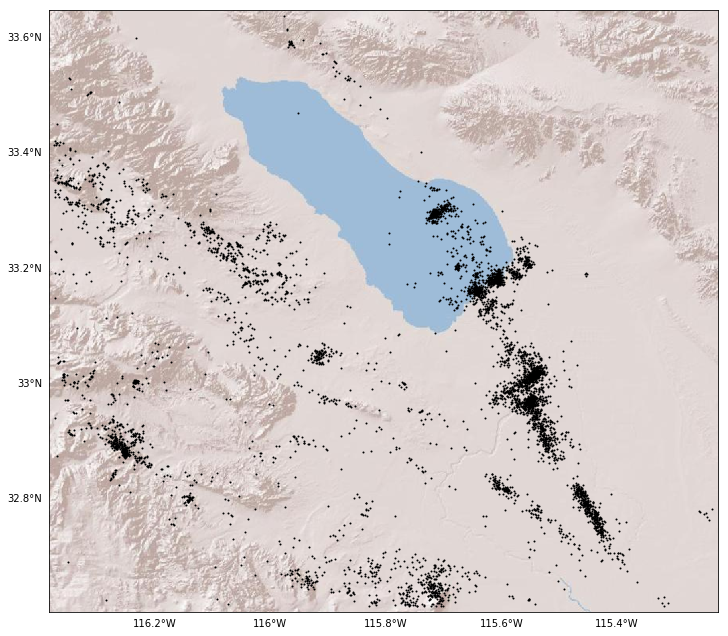

In [5]:
### Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (requires internet connection)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Plot each earthquake as a small black dot
m.plot(event_df.longitude.values,event_df.latitude.values,'ko',ms=1,latlon=True)

# And view
plt.show()
plt.close()

-------------
-------------
-------------


## Introduction to Cluster Analysis using scikit-learn

Today, we'll use the python machine learning package `scikit-learn (sklearn)` to identify spatial clusters in our earthquake catalog. While this is perhaps not the most exciting application of unsupervised learning to seismology, it is beginner-friendly and lends itself to visual examples, which help us understand the strengths and limitations of each technique.

We'll focus in particular on three clustering algorithms, some of which you may (or may not) have heard of before:
- `KMeans` clustering: a centroid-based algorithm
- `Agglomerative` clustering: a hierarchical algorithm
- `DBSCAN` clustering: a density-based algorithm

``KMeans`` is likely the most popular algorithm due to its simplicity, though as we'll see below it might not be the best choice for this particular application.



----------------------
-----------


`sklearn` supports a number of different clustering algorithms, including the three highlighted above. One of the reasons there are so many is that each algorithm has its own strengths and limitations, and different ones work for different types of clustering problems. A good example of this is provided on the `sklearn` tutorial site (https://scikit-learn.org/stable/modules/clustering.html), where different types of spatial clustering problems are tackled by each algorithm in turn.

<img src="../figs/sklearn_clustering.png">

We'll return to this figure at the end of the tutorial, but for now take note of the differences between ``KMeans`` (first column on the left), ``AgglomerativeClustering`` (one column right of center), and ``DBSCAN`` (one column to the right of that).

---------------
---------------
Before clustering, we need to do a bit of preprocessing to convert our earthquakes into "features". Clustering algorithms search for natural groupings within datasets such that data samples within a group are "close by" in feature space, while samples that are in different groups are more distant. 

In this simple example, we'll cluster based on a simple Euclidean distance metric between earthquakes. So our``sklearn`` "feature matrix" $X$ has two columns: the $x$ and $y$ map coordinate of each data sample (here, an earthquake indexed by $i$):

\begin{equation}
X = \begin{bmatrix}
       x_0 & y_0 \\[0.3em]
       x_1 & y_1 \\[0.3em]
       ... & ...  \\[0.3em]
       x_{n-1} & y_{n-1}
     \end{bmatrix}
\end{equation}

For those unfamiliar with ``python``, array indexing starts at 0, not 1.

Note that for many clustering algorithms, it is important that the individual features are properly normalized (as is true by default for our map coordinates). Otherwise, when we calculate the euclidean distance between points, it will be dominated by the features with the highest variance.

In [6]:
### Data preprocessing: assemble sklearn feature matrix

# First, get lat/lon data and project into map coordinates
coords = event_df.loc[:,['longitude','latitude']].values
x, y = proj(coords[:,0], coords[:,1]) # mercator coordinates, meters

# Now assemble feature matrix XX of shape [nsamples, nfeatures]
XX = np.array([x,y]).T
print('Feature matrix shape:',XX.shape)

# Convert from meters to kilometers
XX/=1000.


Feature matrix shape: (5463, 2)


This next cell just defines a function to convert an integer into a RGB color. This is handy for plotting colors on a map.

In [7]:
###  Before plotting, let's write a function to get colors for different clusters

def get_cmap(N,cmap='nipy_spectral'):
    '''
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color. The default color map is nipy_spectral.'
    '''
    import matplotlib.cm as cm
    import matplotlib.colors as cl
    
    # Set the min and max value expected from the inputs
    color_norm  = cl.Normalize(vmin=0, vmax=N-1)
    
    # Map a scalar value to the colormap
    scalar_map = cm.ScalarMappable(norm=color_norm, cmap=cmap) 
    
    # Return a list of colors
    clist = scalar_map.to_rgba(np.arange(N))
    return clist

-------------
-------------
-------------

## KMeans Clustering

KMeans is perhaps the most widely used clustering algorithm, in part due to its simplicity and transparency. The basic idea behind `KMeans` is to group the input samples into $K$ groups of equal variance, defined here as the within-cluster sum-of-squares or "inertia". The $K$ clusters are essentially Voronoi cells that contain all data points nearest (in feature space) to the cluster centroid.

Advantages of `KMeans` include:
- Ease of understanding and implementation, even without access to machine learning APIs.
- Widespread use, which makes it a good benchmark algorithm.
- Computational efficiency; scales well to problems with a large number of samples.

Disadvantages of `KMeans` include:
- Requires specifying the number of clusters, $K$, apriori.
- The distance metric between samples is assumed to be Euclidean.
- Does not generalize well to problems with asymmetric clusters or uneven cluster sizes.
- Tends to work poorly for high-dimensional feature spaces.

------------
------------
The `KMeans` algorithm is an iterative procedure that can be understood conceptually in the following steps:
0. Initialize the $K$ cluster centroids. One simple implementation is to do this randomly, but in practice it helps if these initial centroid locations aren't too close together. ``sklearn`` ensures this by default using a "k-means++' initialization scheme.
1. Given the current set of cluster centroids, assign each sample to the cluster with the nearest centroid. The clusters thus defined Voronoi cells in feature space.
2. With the new cluster assignments in hand, update the cluster centroids by taking the mean vector in feature space.

Steps 1 and 2 are iterated until the cluster locations converge. Since the initialization is quasi-random, often `KMeans` is performed several times, and the results averaged, to ensure that the clusters are not sensitive to the vagaries of initialization randomization.

Graphically, this looks something like this:

<img src="../figs/kmeans.png">

One can show that the `KMeans` algorithm is equivalent to minimizing the within-cluster variance, or inertia:
\begin{equation}
minimize \; \sum_j \sum_i (x_i - \mu_j)^2,
\end{equation}
where $\mu_j$ is the centroid of cluster $j$. By minimizing the inertia in this way, `KMeans` tends to produce isotropic clusters that are relatively even in size, which can be a plus or a minus depending on the problem at hand.

----------------
----------------
Ok, enough background! Let's get started. The main hyperparameter controlling `KMeans` clustering is `n_clusters`, which does exactly what it sounds like. Let's start with a value of 3 and go from there.

Notice that ``sklearn`` is an object-oriented API. The results of the clustering algorithm are stored in object data structures, which have a set of corresponding functions and properties that can accessed with a "." operation.

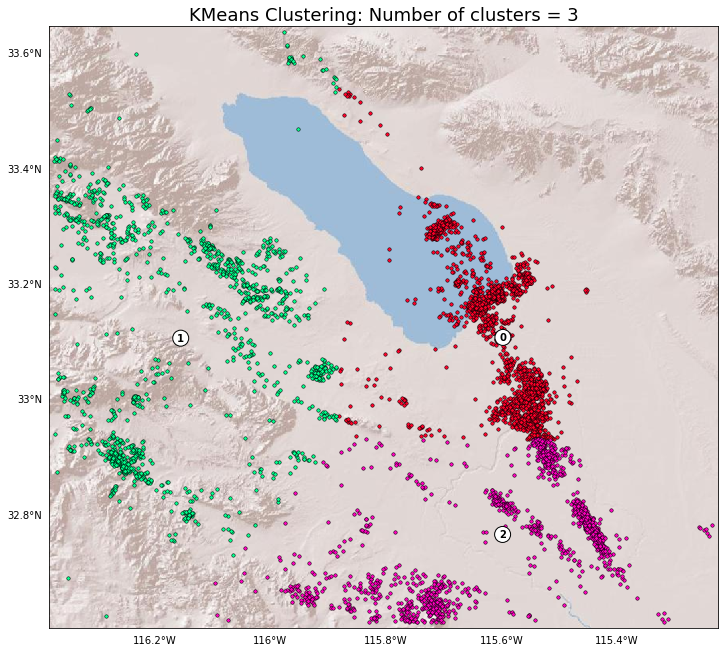

In [8]:
### Cluster the earthquake dataset using KMeans

# Import sklearn module
from sklearn.cluster import KMeans

### Now use sklearn to compute clusters. 
# - Notice here we use an 'k-means++' randomized initialization, with results averaged over 10 realizations. 
# - n_jobs=-1 takes advantage of parallel processing where possible.
n_clusters = 3
clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0, n_jobs=-1).fit(XX)

# Get cluster labels: a unique digit for each cluster, starting at 0
cluster_labels = clustKM.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be the same as the n_clusters we put in 

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'KMeans Clustering: '
ttlstr += 'Number of clusters = {:}'.format(n_clusters)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

----------
----------
As discussed above, the two main limitations with KMeans is that the number of clusters needs to be specified apriori, and that the clusters tend to be isotropic and homogenous in size, even when this is undesirable. In our problem, `KMeans` with 3 clusters produces large, diffuse clusters with noticeable problems near the cluster boundaries. The isotropic nature of the clusters is also problematic, since natural fault systems are elongated.

--------
--------
While the cluster isotropy problem is difficult to address within the context of `KMeans` -- we need to do some fancy feature transformation or pick another algorithm entirely -- there are objective ways of determining the optimal number of clusters. One popular way of doing so is using what are called "silhouette" scores. While silhouette analysis is not without its limitations, it's worth getting a feel for how it works in practice.

In brief, the silhouette score $s$ depends on two things:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster.

To calculate the silhouette score $s$ for each sample, one computes:
\begin{equation}
s = \frac{b-a}{max(a,b)},
\end{equation}
and the silhouette coefficient $S$ for a dataset as a whole is given as the mean of the individual coefficients $s$. 

Conceptually, a well-performing clustering algorithm would give small $a$ values and large $b$ values. The silhouette score is a normalized metric of this intuition that is bounded between -1 and 1, with higher scores indicating better clustering (dense and well-separated clusters). 

One common way to use silhouette analysis is to choose the number of clusters than maximizes the mean silhouette score. There can be limitations to this simple approach, but it can be useful in practice. Note that while silhouette scores can be computed for any clustering algorithm (with equivalent distance metrics), it is difficult to compare scores between two different algorithms, which make different assumptions about what a "good" clustering is. 


-------------
`sklearn` has tools to perform silhouette analysis built into its API. Let's compute silhouette values for a range of different cluster sizes and see what happens.

For n_clusters =  2, the average silhouette_score is: 0.516.
For n_clusters =  3, the average silhouette_score is: 0.480.
For n_clusters =  4, the average silhouette_score is: 0.493.
For n_clusters =  5, the average silhouette_score is: 0.549.
For n_clusters =  6, the average silhouette_score is: 0.582.
For n_clusters =  7, the average silhouette_score is: 0.599.
For n_clusters =  8, the average silhouette_score is: 0.614.
For n_clusters =  9, the average silhouette_score is: 0.624.
For n_clusters = 10, the average silhouette_score is: 0.618.
For n_clusters = 11, the average silhouette_score is: 0.601.
For n_clusters = 12, the average silhouette_score is: 0.596.
For n_clusters = 13, the average silhouette_score is: 0.589.
For n_clusters = 14, the average silhouette_score is: 0.569.
For n_clusters = 15, the average silhouette_score is: 0.568.
For n_clusters = 16, the average silhouette_score is: 0.536.
For n_clusters = 17, the average silhouette_score is: 0.538.
For n_clusters = 18, the

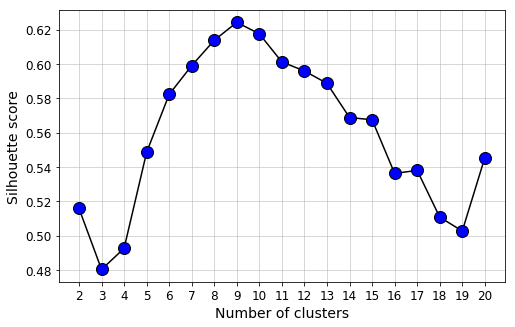

In [9]:
### Compute silhouette scores

# Import sklearn silhouette functions
from sklearn.metrics import silhouette_samples, silhouette_score

# Loop over a range of cluster sizes
test_nclusters = np.arange(2,21)
test_silhouettes = np.zeros(test_nclusters.size)
for nn, n_clusters in enumerate(test_nclusters):
    
    # Get KMeans clusters and labels for this size
    clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0, n_jobs=-1).fit(XX)
    cluster_labels = clustKM.labels_
    
    # Get the average silhouette scores across samples and print
    silhouette_avg = silhouette_score(XX, cluster_labels)
    print("For n_clusters = {:2d}, the average silhouette_score is: {:.3f}.".format(n_clusters,silhouette_avg))
    test_silhouettes[nn] = silhouette_avg


## Plot results

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5,forward=True)

# Plot silhouette scores
ax.plot(test_nclusters,test_silhouettes,'-o',c='k',mfc='b',mec='k',ms=12)

# Format axis
ax.set_xlabel('Number of clusters',fontsize=14)
ax.set_ylabel('Silhouette score',fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xticks(test_nclusters)
ax.grid(lw=0.5)

# Show
plt.show()
plt.close()

From the results above, it appears that 9 clusters gives the optimal silhouette score, but anything between 7 and 13 appears defensible.

----
Sometimes it can be useful to visualize the distribution of silhouette scores across each cluster, not just the dataset-wide average. These are called "silhouette plots". Let's make a few just to see how what they look like, here testing clusters sizes of 3, 9, and 15.

For n_clusters =  3, the average silhouette_score is: 0.480.
For n_clusters =  9, the average silhouette_score is: 0.624.
For n_clusters = 15, the average silhouette_score is: 0.568.


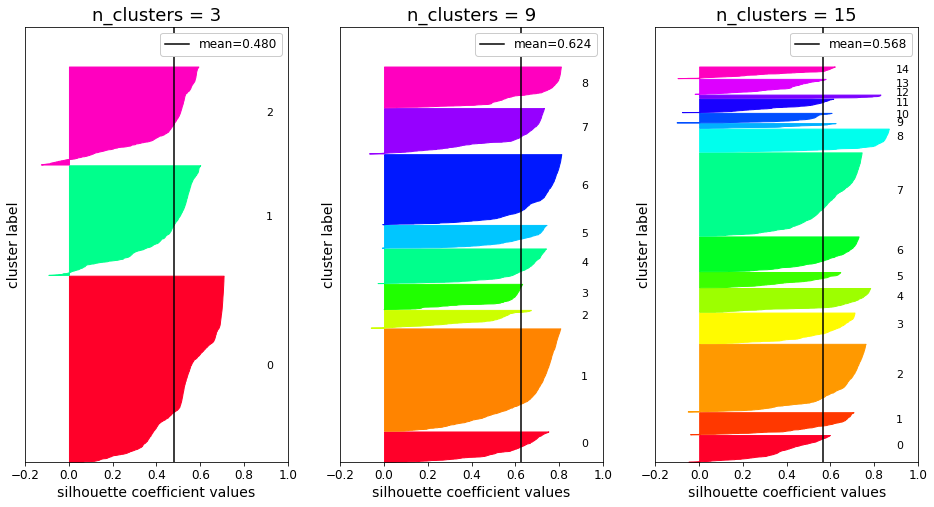

In [10]:
### Silhouette plots

# Let's try these cluster sizes
nclust_list = [3,9,15]

# Make one subplot per cluster size
fig, ax = plt.subplots(1,3,sharex=True)
fig.set_size_inches(16,8,forward=True)

# Loop over cluster sizes
for nn, n_clusters in enumerate(nclust_list):
    
    # Select axis on which to plot
    ax1 = ax[nn]
    
    # Get KMeans clusters and labels for this size.
    clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0, n_jobs=-1).fit(XX)
    cluster_labels = clustKM.labels_
    
    # Get the average silhouette scores across samples and print
    silhouette_avg = silhouette_score(XX, cluster_labels)
    print("For n_clusters = {:2d}, the average silhouette_score is: {:.3f}.".format(n_clusters,silhouette_avg))

    # Compute the silhouette scores for each sample
    silhouette_values = silhouette_samples(XX, cluster_labels)


    # Get different color for different cluster
    cmaps = get_cmap(n_clusters,cmap='gist_rainbow')
    
    # Loop over clusters and plot the distribution of cluster sizes 
    y_lower = 0
    for ii in range(n_clusters):
                                           
        # Sort the silhouette values for cluster ii
        svals_ii = np.sort(silhouette_values[cluster_labels == ii])

        # Select color for cluster ii
        color = cmaps[ii]
        
        # Plot the distribution of silhouette scores
        ninclust_ii = svals_ii.shape[0]
        y_upper = y_lower + ninclust_ii
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, svals_ii,
                          facecolor=color, edgecolor=color, alpha=1.0)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0.9, y_lower + 0.5 * ninclust_ii, str(ii),fontsize=11)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # this allows a bit of padding

    # Label the plot and axes
    ax1.set_title('n_clusters = {:}'.format(n_clusters),fontsize=18)
    ax1.set_xlabel("silhouette coefficient values",fontsize=14)
    ax1.set_ylabel("cluster label",fontsize=14)

    # Plot a vertical line for the silhouette average
    ax1.axvline(x=silhouette_avg, color="k", linestyle="-",label='mean={:.3f}'.format(silhouette_avg))
    ax1.legend(loc='upper right',fontsize=12,framealpha=1.0)
    
    # Format the x and y limits and axes
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xlim((-0.2,1.0))
    ax1.set_ylim((0,1.1*y_upper))
    ax1.tick_params(labelsize=12)
    
# Show all subplots
plt.show()
plt.close()

---------
For `n_clusters`=9, the distributions of silhouette values are pretty consistent from cluster to cluster and on average higher than for `n_clusters`=3. These plots are sometimes hard to interpret, so I wouldn't make too much of them. It does however illustrate that by just using the average silhouette score as is commonly done, we are throwing away a lot of information that may be potentially useful in selecting the optimal number of clusters.

----- 
-----
Finally, let's plot a map for `n_clusters` = 9, the optimal value from the silhouette analysis.

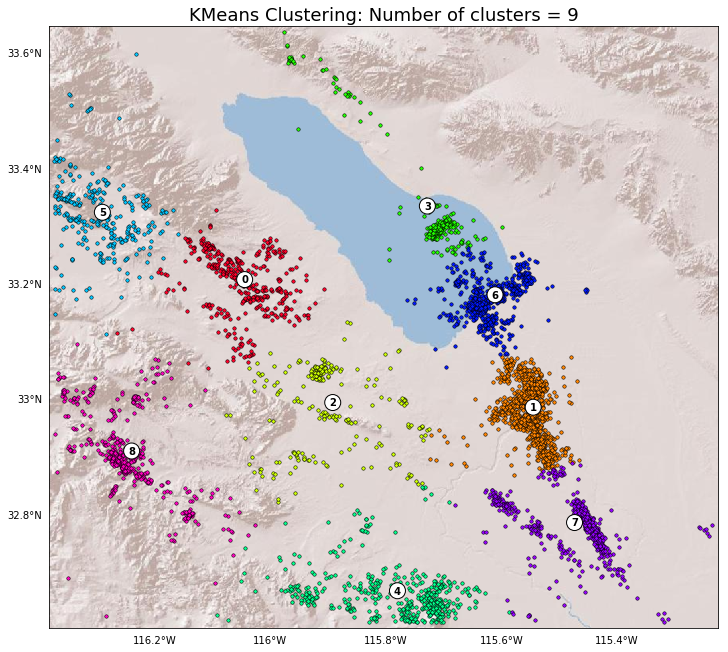

In [11]:
### Plot a map for n_clusters = 9

# Use sklearn to compute clusters
n_clusters = 9
clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0, n_jobs=-1).fit(XX)

# Get cluster labels: a unique digit for each cluster
cluster_labels = clustKM.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be 10

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'KMeans Clustering: '
ttlstr += 'Number of clusters = {:}'.format(n_clusters)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

A bit better, but definitely not perfect. The clusters in the western half of the map seem pretty reasonable, but the edge effects are still pretty noticeable in regions of dense seismicity

--------
---------
---------

## Agglomerative (Hierarchical) Clustering

Agglomerative clustering is another commonly applied approach to clustering based on representing the dataset in a tree-like structure known as a hierarchy. In agglomerative (or "bottom-up") clustering, each data sample initially begins as its own cluster of one. The clustering algorithm then links clusters that are nearby in feature space, beginning with the nearest and proceeding through the entire dataset (in order of distance) until all of the samples comprise a single cluster. This procedure forms a hierarchical representation of the dataset, which can be truncated at different distance thresholds to partition the dataset into a desired number of clusters. For example, if we have 100 samples data points, the clustering algorithm will eventually link all 100 of these points together in a single cluster, but we can effectively terminate this procedure early to define any number of clusters from 1 to 100.

Graphically, agglomerative clustering works something like this:

<img src="../figs/agglomerative.png">

The ``sklearn`` implementation of ``AgglomerativeClustering`` requires ``n_clusters`` to be specified apriori and does not contain explicit tools to visualize the hierarchical tree. This is kind of unfortunate, but in this section of the tutorial I'll provide some alternative python-based tools to facilitate application of ``AgglomerativeClustering`` to our earthquake catalog dataset.

Advantages of ``AgglomerativeClustering`` include:
- Can use a distance threshold to select the number of clusters.
- Can visualize the structure of the clustering hierarchy between data points.
- Not limited to spherical or isotropic clusters, or to quasi-uniform cluster sizes.
- Can be generalized to include non-Euclidean distance metrics.

Disadvantages of ``AgglomerativeClustering`` include:
- Doesn’t scale very well to large data sets (and the clustering hierarchy can be difficult to visualize in practice, as we will see below).
- The right number of clusters can be difficult to determine.
- There is no mathematical objective function to optimize (a graphical heuristic algorithm).
- Need to specify two different metrics: sample-to-sample "distance" and cluster-to-cluster "linkage".

---------------
---------------
#### Distances between samples and between clusters

In agglomerative clustering, we need to specify how we would like to measure two different types of distances: between individual data points and between clusters. The between-cluster distance metric is known as the ``linkage`` criterion, and the algorithm will progressively merge pairs of clusters that minimize this criterion. Commonly used ``linkage`` criteria implemented in ``sklearn`` include:

- ``single``: the minimum of the distances between all observations of the two clusters.
- ``average``: the average of the distances of each observation of the two clusters.
- ``complete``: the maximum distances between all observations of the two clusters.

<img src = '../figs/linkages.png'>

``single`` is fast to compute but is not very robust to noise in the dataset and tends to produce very uneven cluster sizes. ``average`` linkage often provides a good compromise between ``single`` and ``complete``, and can also be easily generalized to non-Euclidean distance metrics.


---------------
Ok, let's get started. First, let's do a simple test of ``AgglomerativeClustering`` with ``average`` linkage and 10 clusters.

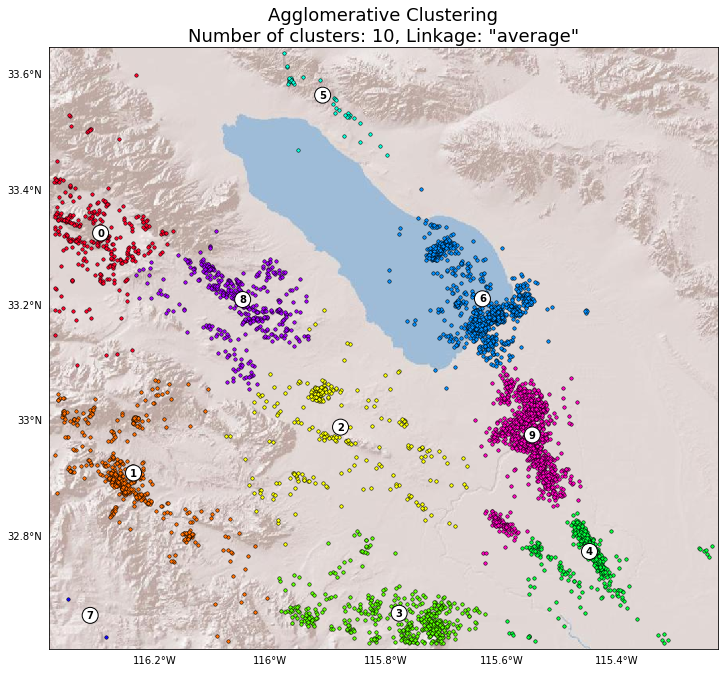

In [12]:
### Import sklearn module
from sklearn.cluster import AgglomerativeClustering

# Use sklearn to compute clusters
n_clusters = 10
linkage = 'average'
clustAC = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean').fit(XX)

# Get cluster labels:
cluster_labels = clustAC.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be 10

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'Agglomerative Clustering\n'
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ttlstr += ', Linkage: "{:}"'.format(linkage)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

Nice, this seems like a promising start. The edge effects seem improved from before. One thing to notice is that the cluster sizes are no longer very uniform. Take a look at the baby clusters 5 and 7 in the southwest corner and northern part of the map!

-------------
One way to visualize results of AgglomerativeClustering is using a "dendrogram". Unfortunately, ``sklearn`` does not provide a built in function for this. Luckily, ``scipy``, another powerful python scientific computing package does. The hierarchical clustering algorithm in ``scipy`` is similar in spirit to the ``sklearn`` version (though note that the cluster ID numbers and associated colors will often differ). 

The first step to making a dendrogram plot is to compute a linkage matrix, which essentially tracks the series of cluster links that build up the tree. Next, one picks a cutoff distance, and all subtrees with linkages less than this distance form a single cluster. The example below uses a cutoff distance of 30km, which produces 8 clusters. See if you can spot the smallest one!

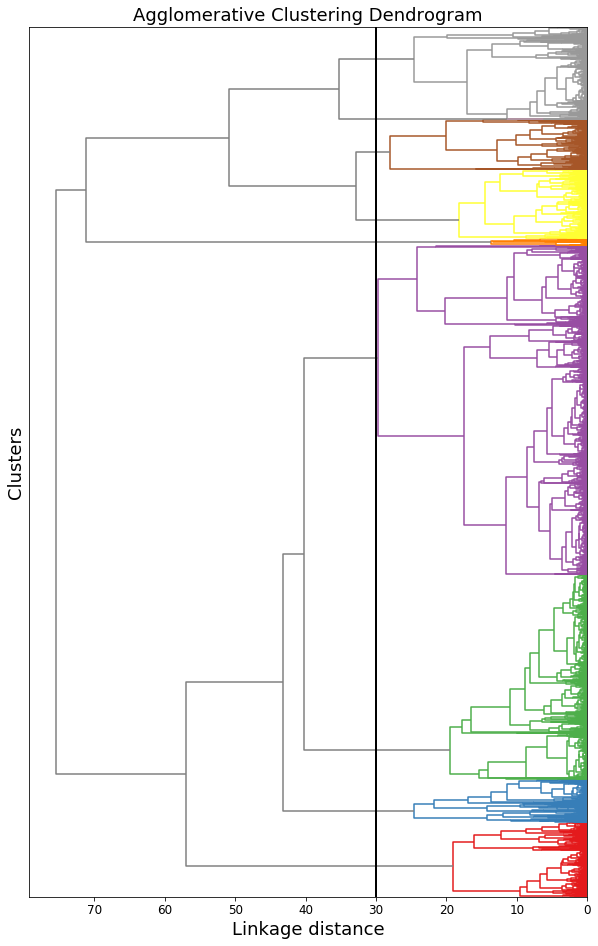

In [13]:
### Dendrogram Plot
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import rgb2hex

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,16,forward=True)


## Compute linkage matrix
#    A N-1 by 4 matrix Z is returned. At the ith iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined 
#    to form cluster (n + i). A cluster with an index less than N corresponds to one of the original observations.
#    The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] 
#   represents the number of original observations in the newly formed cluster.
linkage_XX = linkage(XX,method='average', metric='euclidean')


# Choose a cutoff distance and plot
cutoff_distance = 30.
ax.plot([cutoff_distance,cutoff_distance],[0,1e15],'-',color='black',lw=2,zorder=1e3)

# Plot the dendogram, coloring each cluster
#  notice that each subtree below a cutoff distance is its own color
set_link_color_palette([rgb2hex(rgb) for rgb in get_cmap(10,'Set1')]) # this sets the colors for each cluster
dd = dendrogram(linkage_XX,no_labels=True,ax=ax,orientation='left',
                color_threshold=cutoff_distance,above_threshold_color='gray')


# Format axis
ax.tick_params(labelsize=12)
ax.set_xlabel('Linkage distance',fontsize=18)
ax.set_ylabel('Clusters',fontsize=18)
plt.title('Agglomerative Clustering Dendrogram',fontsize=18)

# Show
plt.show()
plt.close()

We can use a dendrogram like the one above to visually select the appropriate number of clusters. Here, 8-12 again looks reasonable, which correspond to distance cutoffs in the 20-30 range (a lower cutoff results in more clusters).

Another way of choosing the number of clusters is using the silhouette score introduced above. Let's compare average and complete linkage criteria and plot maps of the best ones.


Linkage: average
-----------------------------------------------------------
For n_clusters =  2, the average silhouette_score is: 0.516.
For n_clusters =  4, the average silhouette_score is: 0.409.
For n_clusters =  6, the average silhouette_score is: 0.420.
For n_clusters =  8, the average silhouette_score is: 0.562.
For n_clusters = 10, the average silhouette_score is: 0.611.
For n_clusters = 12, the average silhouette_score is: 0.599.
For n_clusters = 14, the average silhouette_score is: 0.585.
For n_clusters = 16, the average silhouette_score is: 0.586.
For n_clusters = 18, the average silhouette_score is: 0.564.
For n_clusters = 20, the average silhouette_score is: 0.549.
Maximum score: 0.611, n_clusters = 10

Linkage: complete
-----------------------------------------------------------
For n_clusters =  2, the average silhouette_score is: 0.279.
For n_clusters =  4, the average silhouette_score is: 0.459.
For n_clusters =  6, the average silhouette_score is: 0.346.
For n_cluste

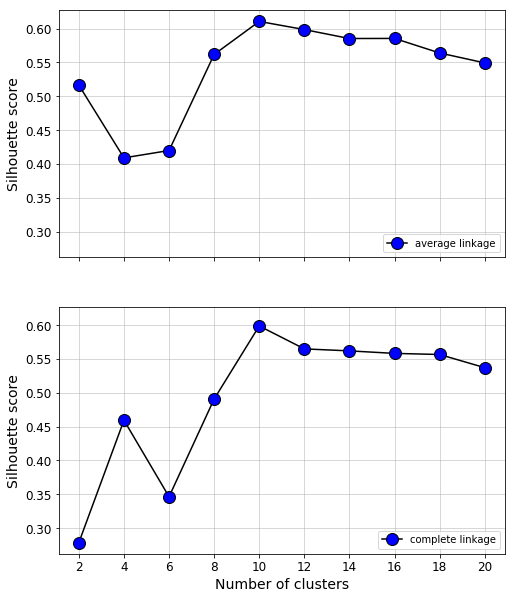

In [14]:
### Compute silhouette scores

# Import sklearn silhouette functions
from sklearn.metrics import silhouette_samples, silhouette_score

# Figure setup, one subplot per linkage
fig, axi = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_size_inches(8,10,forward=True)


# Loop over linkage criteria
for ii, linkage in enumerate(['average','complete']):


    # current linkage
    print('\nLinkage:',linkage)
    print('-----------------------------------------------------------')
    
    # Loop over a range of cluster sizes
    test_nclusters = np.arange(2,21,2)
    test_silhouettes = np.zeros(test_nclusters.size)
    for nn, n_clusters in enumerate(test_nclusters):

        # get KMeans clusters and labels for this size.
        clustAC = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean').fit(XX)
        cluster_labels = clustAC.labels_

        # get the average silhouette scores across samples and print
        silhouette_avg = silhouette_score(XX, cluster_labels)
        print("For n_clusters = {:2d}, the average silhouette_score is: {:.3f}.".format(n_clusters,silhouette_avg))
        test_silhouettes[nn] = silhouette_avg


    # print best
    imax = np.argmax(test_silhouettes)
    print('Maximum score: {:.3f}, n_clusters = {:2d}'.format(test_silhouettes[imax],test_nclusters[imax]))
    
    ## Plot results
    ax = axi[ii]
    
    # plot silhouette scores
    ax.plot(test_nclusters,test_silhouettes,'-o',c='k',mfc='b',mec='k',ms=12,label=linkage +' linkage')

    # format axis
    if ii == len(axi)-1: ax.set_xlabel('Number of clusters',fontsize=14)
    ax.set_ylabel('Silhouette score',fontsize=14)
    ax.legend(loc='lower right')
    ax.tick_params(labelsize=12)
    ax.set_xticks(test_nclusters)
    ax.grid(lw=0.5)

# show final plot
plt.show()
plt.close()

So it appears 10 was a good choice after all! Let's compare maps.

### Map for average linkage

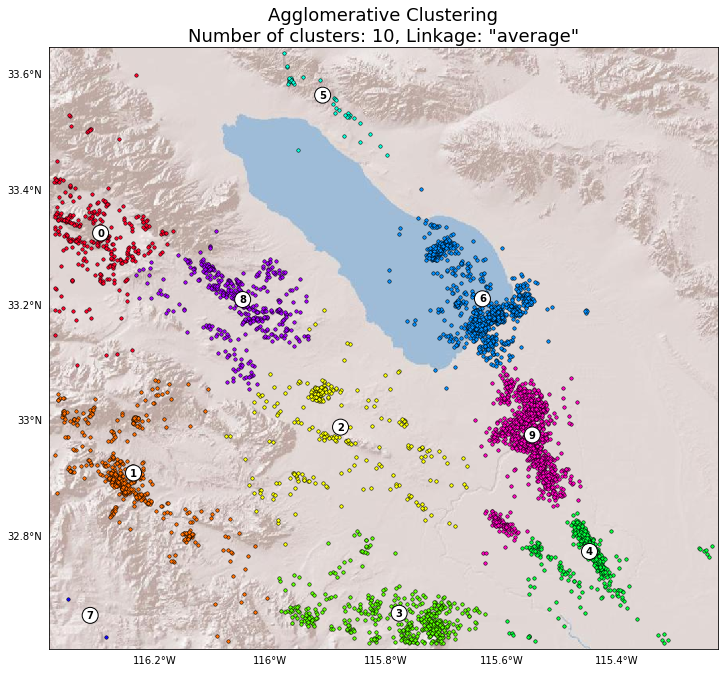

In [15]:
### Use sklearn to compute clusters
n_clusters = 10
linkage = 'average'
clustAC = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean').fit(XX)

# Get cluster labels:
cluster_labels = clustAC.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be 10

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'Agglomerative Clustering\n'
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ttlstr += ', Linkage: "{:}"'.format(linkage)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

### Map for complete linkage

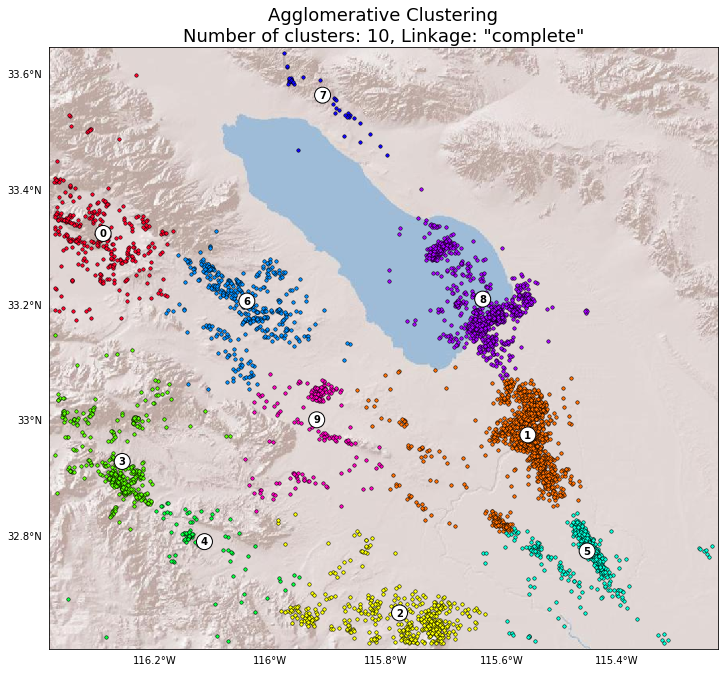

In [16]:
### Use sklearn to compute clusters
n_clusters = 10
linkage = 'complete'
clustAC = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity='euclidean').fit(XX)

# get cluster labels:
cluster_labels = clustAC.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be 10

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'Agglomerative Clustering\n'
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ttlstr += ', Linkage: "{:}"'.format(linkage)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

-------------------------
-------------------------
Which linkage criterion do you think does the best job here? The differences don't seem to be too pronounced in this case.

One other neat thing about AgglomerativeClustering is that (for most linkage criteria) you can use any of a number of distance metrics, so not just "euclidean", but also "manhattan", "cosine", or in fact any "precomputed" distance metric. For example, the "manhattan" metric sums the absoluted differences in feature space (like walking along a city block):

<img src = "../figs/manhattan.png">

Let's test this out below.


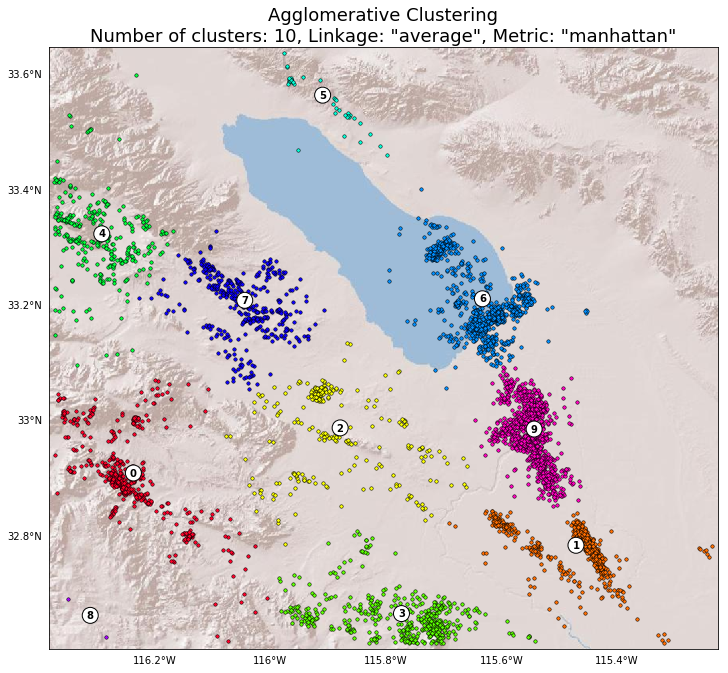

In [17]:
### Test new distance metric: manhattan

# Use sklearn to compute clusters
n_clusters = 10
linkage, metric = 'average', 'manhattan'
clustAC = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=metric).fit(XX)

# Get cluster labels:
cluster_labels = clustAC.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be 10

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'Agglomerative Clustering\n'
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ttlstr += ', Linkage: "{:}", Metric: "{:}"'.format(linkage,metric)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

----------------
Cool! That might have actually worked better than before? Bonus points to the student who comes up with a good explanation why...

Keep in mind that the appropriate distance metric is application-specific, and some of them require careful normalization so that each feature is scaled comparably. Otherwise the euclidean (or manhattan) distance will be dominated by the feature with the higher marginal variance.

----------------
----------------
----------------

## DBSCAN Clustering

Unlike many clustering algorithms, DBSCAN Clustering (Density-Based Spatial Clustering of Applications with Noise) does not require us to define ``n_clusters`` a priori. Instead, DBSCAN automatically determines the number of clusters based on two user-selected hyperparameters: the search radius ``eps`` and the minimum number of samples within this radius, ``min_samples``.

As you might anticipate given its name, DBSCAN is a density-based clustering algorithm that uses the density of points in feature space to identify clusters. Data samples in regions of high density are known as "core" points, which are fundamental to understanding how DBSCAN works. 

The basic algorithm can be summarized heuristically as follows:
0. Select algorithm hyperparameters ``eps`` and ``min_samples``.
1. For each sample data point, draw a sphere in feature space of radius ``eps`` and count the number of samples within this search radius.
2. If this number is greater than or equal to ``min_samples``, the center data point is defined to be a core point, essentially the nucleus of a new cluster containing all of the neighboring points within a radius ``eps``.
3. Loop through all sample points in the dataset, repeating steps 2 and 3 to form new clusters, and linking overlapping clusters (with mutual data points) where necessary.

<img src="../figs/dbscan.png">

Note that the procedure described aboved, sample data points in regions of low density will not be assigned to a cluster, and are termed "outlier" points. The presence of outlier data points also distinguishes ``DBSCAN`` from ``KMeans`` and ``AgglomerativeClustering``, in which each data point is assigned to one of the selected clusters. 

Advantages of ``DBSCAN`` clustering include:
- No need to select number of clusters a-priori; automatically selected based on readily interpretable hyperparameters.
- Can generalize to non-uniform cluster sizes and non-isotropic cluster shapes.
- Computationally efficient, scalable algorithm.
- Can generalize to non-Euclidean distances (with some care!).

Disadvantages of ``DBSCAN`` clustering include:
- Clusters are sensitive to choice of two hyperparameters: ``eps`` and ``min_samples``.
- Outlier data points (can be a pro or con depending on application).

---------

Let's start out with ``eps`` = 2.0 and ``min_samples`` = 5, and go from there. Note that this the units of ``eps`` in this case are kilometers, since that's how we normalized our feature matrix.


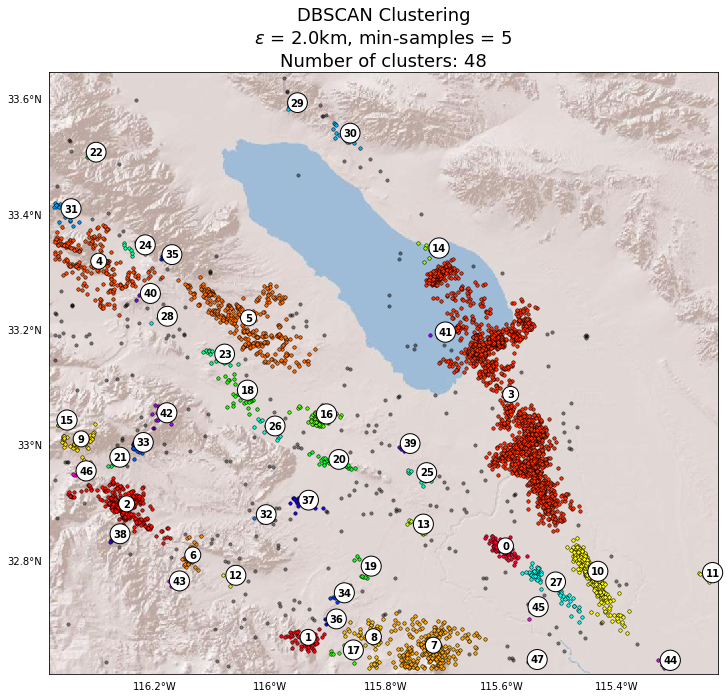

In [18]:
### Use sklearn to compute clusters
from sklearn.cluster import DBSCAN
eps = 2.0 # search radius, km
min_samples = 5 # minimum number of samples in search radius
clustDB = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1).fit(XX)

# get cluster labels:
#   note that -1 is an outlier point
cluster_labels = clustDB.labels_
n_clusters = len(np.unique(cluster_labels)) - 1 # this does not count outliers, which have a value of -1

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)


# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Plot the outliers in gray
iclust = cluster_labels == -1
clons, clats = coords[iclust,0], coords[iclust,1]
m.scatter(clons,clats,12,marker='o',color='k',alpha=0.5,latlon=True,edgecolors='k',linewidths=0.5)

# Title
ttlstr = 'DBSCAN Clustering\n'
ttlstr +='$\epsilon$ = '+'{:.1f}km'.format(eps)+', min-samples = ' + '{:}\n'.format(min_samples)
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

Wow, that's a lot of clusters! On the plus side, the clusters do appear to be spatially coherent, with no obvious edge effects. Also note the outlier data points, shown in gray. 

We can again try to use silhouette analysis to optimize our hyperparameters (``eps`` and ``min_samples``), but in my experience this can give inconsistent results with DBSCAN because of the presence of the outlier data points. Still, let's see what happens if we vary both ``min_samples`` and ``epsilon``.


min_samples: 5
-----------------------------------------------------------
For eps = 2.0, the average silhouette_score is: 0.054.
For eps = 4.0, the average silhouette_score is: 0.091.
For eps = 6.0, the average silhouette_score is: -0.045.
For eps = 8.0, the average silhouette_score is: -0.018.
For eps = 10.0, the average silhouette_score is: 0.013.
For eps = 12.0, the average silhouette_score is: 0.086.
For eps = 14.0, the average silhouette_score is: 0.086.
For eps = 16.0, the average silhouette_score is: 0.349.
For eps = 18.0, the average silhouette_score is: 0.349.
For eps = 20.0, the average silhouette_score is: 0.349.
Maximum score: 0.349, eps = 16.0

min_samples: 10
-----------------------------------------------------------
For eps = 2.0, the average silhouette_score is: 0.167.
For eps = 4.0, the average silhouette_score is: 0.102.
For eps = 6.0, the average silhouette_score is: 0.418.
For eps = 8.0, the average silhouette_score is: 0.291.
For eps = 10.0, the average silhouet

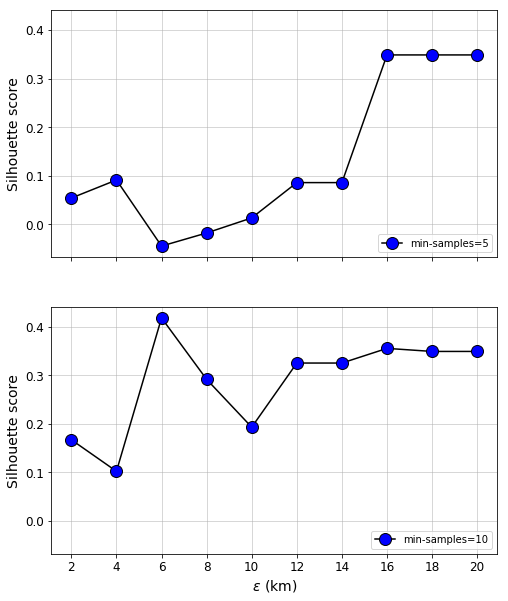

In [19]:
### Compute silhouette scores

# Import sklearn silhouette functions
from sklearn.metrics import silhouette_samples, silhouette_score

# Figure setup, one subplot per linkage
fig, axi = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_size_inches(8,10,forward=True)


# Loop over different min_samples
for ii, min_samples in enumerate([5, 10]):


    # Current linkage
    print('\nmin_samples:',min_samples)
    print('-----------------------------------------------------------')
    
    # Loop over a range of cluster sizes
    test_eps = np.arange(2.,20.1,2.)
    test_silhouettes = np.zeros(test_eps.size)
    for nn, eps in enumerate(test_eps):

        # Get DBSCAN clusters and labels for these hyperparameters
        clustDB = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1).fit(XX)
        cluster_labels = clustDB.labels_

        # Get the average silhouette scores across samples and print
        silhouette_avg = silhouette_score(XX, cluster_labels)
        print("For eps = {:.1f}, the average silhouette_score is: {:.3f}.".format(eps,silhouette_avg))
        test_silhouettes[nn] = silhouette_avg


    # Print best
    imax = np.argmax(test_silhouettes)
    print('Maximum score: {:.3f}, eps = {:.1f}'.format(test_silhouettes[imax],test_eps[imax]))
    
    ## Plot results
    ax = axi[ii]
    
    # Plot silhouette scores
    ax.plot(test_eps,test_silhouettes,'-o',c='k',mfc='b',mec='k',ms=12,label='min-samples={:d}'.format(min_samples))

    # Format axis
    if ii == len(axi)-1: ax.set_xlabel('$\epsilon$ (km)',fontsize=14)
    ax.set_ylabel('Silhouette score',fontsize=14)
    ax.legend(loc='lower right')
    ax.tick_params(labelsize=12)
    ax.set_xticks(test_eps)
    ax.grid(lw=0.5)

# Show final plot
plt.show()
plt.close()

Interesting. Notice that certain combinations of parameters give comparable clusters.

The highest score is for ``eps`` = 6.0, ``min_samples`` = 10. Let's take a look at this.

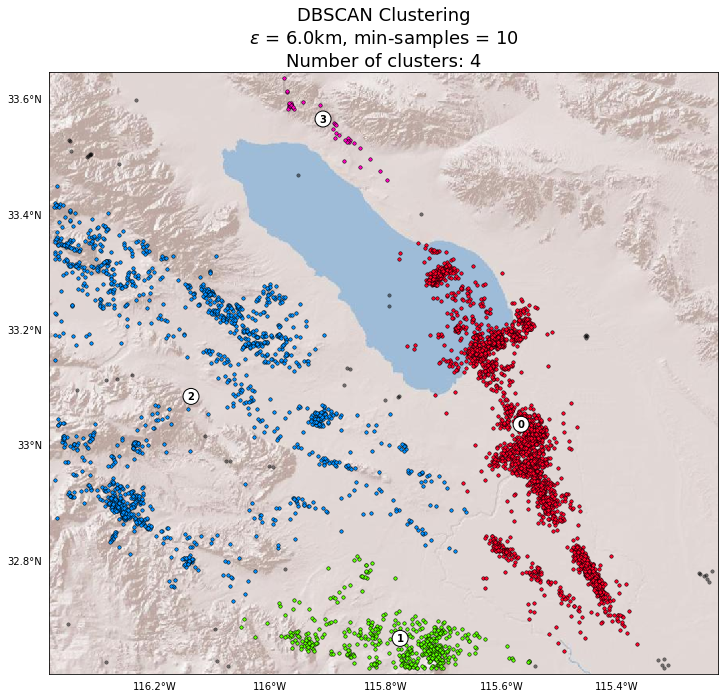

In [20]:
### Use sklearn to compute clusters

eps = 6.0 # search radius, km
min_samples = 10 # minimum number of samples in search radius
clustDB = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1).fit(XX)

# Get cluster labels:
#   note that -1 is an outlier point
cluster_labels = clustDB.labels_
n_clusters = len(np.unique(cluster_labels)) - 1 # this does not count outliers, which have a value of -1

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Plot the outliers in gray
iclust = cluster_labels == -1
clons, clats = coords[iclust,0], coords[iclust,1]
m.scatter(clons,clats,12,marker='o',color='k',alpha=0.5,latlon=True,edgecolors='k',linewidths=0.5)

# Title
ttlstr = 'DBSCAN Clustering\n'
ttlstr +='$\epsilon$ = '+'{:.1f}km'.format(eps)+', min-samples = ' + '{:}\n'.format(min_samples)
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

--------
Well, that is certainly is one way to partition that dataset into clusters, though it isn't exactly what I had in mind.

One of the nice things about DBSCAN is that its two hyperparameters, ``eps`` and ``min_samples`` have a physical interpretation. This makes it easier to use our own "domain knowledge" as seismologists to help select reasonable values. To me, a search radius ``eps`` in the ballpark of 3-5km with ``min_samples`` ~ 5 is about what I have in mind when I conceptualize spatial clusters of earthquakes. 

Let's try this out below. Feel free to play around with the hyperparameters to select the best choices.

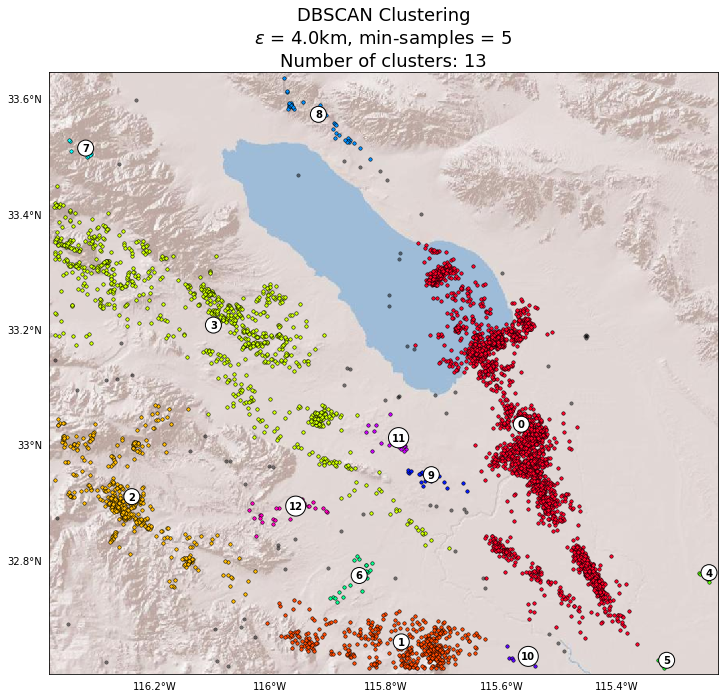

In [21]:
### Test eps = 4, min_samples = 5
eps = 4 # search radius, km
min_samples = 5 # minimum number of samples in search radius
clustDB = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1).fit(XX)

# Get cluster labels:
#   note that -1 is an outlier point
cluster_labels = clustDB.labels_
n_clusters = len(np.unique(cluster_labels)) - 1 # this does not count outliers, which have a value of -1

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Plot the outliers in gray
iclust = cluster_labels == -1
clons, clats = coords[iclust,0], coords[iclust,1]
m.scatter(clons,clats,12,marker='o',color='k',alpha=0.5,latlon=True,edgecolors='k',linewidths=0.5)

# Title
ttlstr = 'DBSCAN Clustering\n'
ttlstr +='$\epsilon$ = '+'{:.1f}km'.format(eps)+', min-samples = ' + '{:}\n'.format(min_samples)
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()

This seems fine to me, but remember there is no right answer in unsupervised learning!

-----
-----
-----
## Summary


Let's revisit the ``sklearn`` tutorial figure summarizing different clustering algorithms.

<img src="../figs/sklearn_clustering.png">

Look at the different clustering algorithms, and their performance for different clustering problems. After going through this tutorial, do you have a better sense of why some of the different clustering algorithms perform better on worse on different problems?

---------

To conclude, cluster analysis is one of the central pillars of unsupervised machine learning. There are many different clustering algorithms to chose from, each with their own strengths and limitations. This diversity, while overwhelming at first, is actually a good thing, because it means we can often find an algorithm that is most suitable for the problem at hand. 

Today, we applied different clustering algorithms to the problem of automatically defining spatial clusters within an earthquake catalog from the Salton Sea region of southern California. Using the ``scikit-learn`` python API as our guiding toolset, we learned how to use three different algorithms: the centroid-based ``KMeans`` algorithm, the hierarchical ``AgglomerativeClustering`` algorithm, and the density-based ``DBSCAN`` algorithm. We saw how silhouette analysis can be used to select a viable number of ``KMeans`` clusters, and how dendrogram plots can be used to select a cutoff distance and associated cluster count for ``AgglomerativeClustering``. We also explored how to select ``DBSCAN`` hyperparameters like the search radius ``eps``, both through silhouette analysis and through our domain knowledge in defining spatial clusters of earthquakes.

Ultimately, unsupervised methods like cluster analysis have a degree of subjectivity to them, so one shouldn't worry so much about selecting the perfect technique and algorithm parameters, but instead focus on making appropriate and justifiable selections for a given task. This tutorial is just a starting point for applications of clustering to seismology, but hopefully you found it to be informative. Thanks for your attention and interest in today's workshop! For those that are interested in digging a bit further, I provide a ``SpectralClustering`` homework problem below using the same dataset.

-- Daniel Trugman, Los Alamos National Laboratory (dtrugman@lanl.gov)

## Spectral Clustering: A Homework Assignment!

``SpectralClustering`` is a more "advanced" technique that is a bit harder to wrap one's head around than the three canonical algorithms described above. But in its essence, ``SpectralClustering`` defines clustering based on the notion of connectedness, which can be quantified in terms of an affinity matrix.

Conceptually, an affinity matrix is the opposite of a distance matrix, and is essentially a normalized measure of the pairwise similarity between data samples. An affinity matrix can be formed, for example, by applying a kernel transformation such as a radial basis function to the pairwise distance, $d(x_i,x_j)$:
\begin{equation}
A_{ij} = \exp \; [ -\gamma * d(x_i,x_j)^2 ],
\end{equation}
where $\gamma$ is a kernel hyperparameter.

Another common parameterization of an affinity matrix is a K-Nearest-Neighbors matrix, which is highly sparse and contains only nonzero entries for the $K$ nearest neighbors of the data sample corresponding to each row.

The ``SpectralClustering`` algorithm works by performing an eigenvalue decomposition of the normalized Laplacian of the affinity matrix, followed by a ``KMeans`` clustering in the "embedding space" defined by the eigenvectors. Because of this, the desired number of clusters needs to specified apriori, though one can sometimes use a technique called the "eigengap heuristic" to help guide things here.

I find this whole procedure a bit difficult to wrap my head around. But if we visualize our dataset as an interconnected graph structure, one can think of ``SpectralClustering`` as way to find an optimal way to cut the edges of the graph into $K$ coherent clusters.

This cartoon may (or may not) help:

<img src="../figs/spectral.png">

Advantages of ``SpectralClustering`` include:
- Quite general, can apply to non-standard distance metrics (especially graphical ones).
- Not limited to isotropic cluster shapes.
- The underlying notion of graphical connectedness is appealing in many contexts.

Disadvantages of ``SpectralClustering`` include:
- Difficulty in understanding the computational algorithm and in interpreting its results.
- The number of clusters needs to be specified a-priori.
- High computational cost, not very scalable.
- Tends to favor uniform cluster sizes, and works poorly in situations with many clusters.



### Warm up

To get you started, I'll show an example with a nearest-neighbors ``affinity`` matrix and 8 clusters. Note, ``SpectralClustering`` can be computationally intensive, but things will speed up a bit if the ``pyamg`` package is installed.

In [22]:
# Import sklearn module
from sklearn.cluster import SpectralClustering

# This '?' syntax gives an overview of the SpectralClustering module
SpectralClustering?

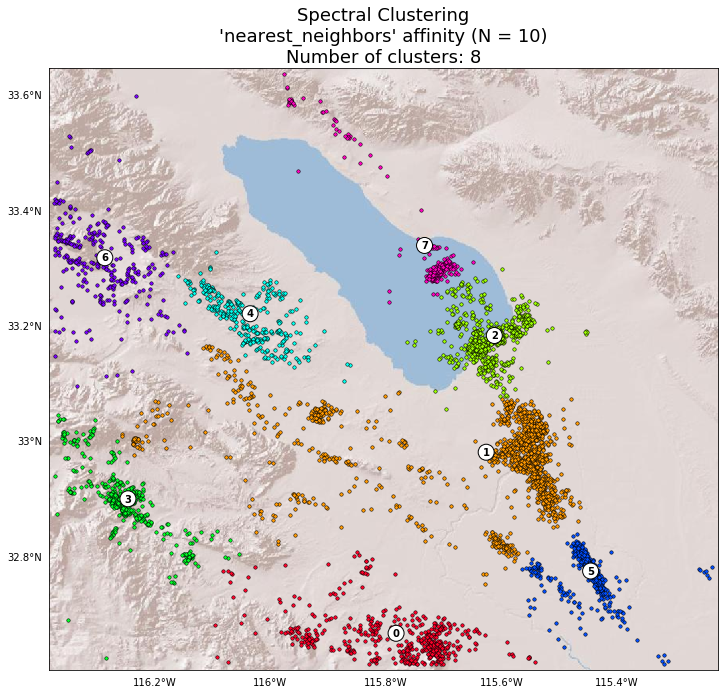

In [23]:
### Example map with nearest neigbhors affinity matrix
affinity = 'nearest_neighbors'
n_clusters = 8 # number of clusters
n_neighbors = 10 # number of neighbors in KNN matrix
clustSC = SpectralClustering(n_clusters=n_clusters, affinity=affinity, n_neighbors=n_neighbors, n_jobs=-1).fit(XX)

# Get cluster labels:
cluster_labels = clustSC.labels_
n_clusters = len(np.unique(cluster_labels)) # this should be 8

## Plot map

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,12,forward=True)

# Attach the mapping object to the current axis
m.axes=ax

# Background of map: shaded relief (this requires an internet connection...)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False)

# Lat/lon grid (lines hidden)
m.drawparallels(np.arange(32.0,34.0,0.2),labels=[1,0,0,0],linewidth=0.)
m.drawmeridians(np.arange(-117.0,-115.0,0.2),labels=[0,0,0,1],linewidth=0.)

# Get different color for different clusters
cmaps = get_cmap(n_clusters,cmap='gist_rainbow')

# Plot different clusters on map, and label cluster number
for nn in range(n_clusters):
    iclust = cluster_labels == nn
    clons, clats = coords[iclust,0], coords[iclust,1]
    m.scatter(clons,clats,12,marker='o',color=cmaps[nn], latlon=True,edgecolors='k',linewidths=0.5)
    ax.annotate(str(nn),xy=(np.mean(clons),np.mean(clats)),zorder=1e10,
                fontsize=10,color='black',fontweight='bold',bbox={'boxstyle': 'circle', 'facecolor': 'white'})
    
# Title
ttlstr = 'Spectral Clustering\n'
if affinity == 'nearest_neighbors': 
    ttlstr += "'{:}' affinity (N = {:})\n".format(affinity,n_neighbors)
else:
    ttlstr += "'{:}' gamma ($\gamma$ = {:.1f})\n".format(affinity,gamma)
ttlstr += 'Number of clusters: {:}'.format(n_clusters)
ax.set_title(ttlstr,fontsize=18)

# And view
plt.show()
plt.close()


### Exercise 1.

In the example above, we used an affinity matrix based on the 10 nearest neighbors. Are the results sensitive to this choice?

In [24]:
## Your code here!

### Exercise 2.

The 'nearest_neighbors' affinity is only one of many choices. Try the 'rbf' (radial basis function or Gaussian) kernel instead. How do the results depend on the kernel parameter, ``gamma``? What is the physical interpretation of ``gamma``, and does this help motivate a reasonable choice?

In [25]:
## Your code here!

### Exercise 3.
The default number of clusters for ``SpectralClustering`` is 8. Can you optimize this value? Feel free to chose your favorite of the 'nearest_neighbor' or 'rbf' affinities (or another choice entirely).

Hint: it may be worthwhile to use a precomputed affinity matrix.

In [26]:
## Your code here!

### References and further reading

I. Background information on cluster analysis

- Bishop C. M.  (2006). Pattern Recognition and Machine Learning , Springer Verlag, New York, New York.
- Murphy K. P. (2012). Machine Learning: A Probabilistic Perspective , MIT Press, Cambridge, Massachusetts.
- Scikit-learn clustering tutorial. https://scikit-learn.org/stable/modules/clustering.html
- Rokach, L., and O. Maimon (2005). "Clustering methods." Data mining and knowledge discovery handbook. Springer US.
- Kaufman L., and P. J. Roussew (1990). Finding Groups in Data - An Introduction to Cluster Analysis. Yeah Wiley-Science Publication, John Wiley & Sons.

II. Technical papers on specific algorithms

- Arthur D. and S. Vassilvitskii (2007). “k-means++: The advantages of careful seeding”. Proceedings of the eightenth annual ACM-SIAM symposium on Discrete algorithms. Society for Industrial and Applied Mathematics.

- Ester, M., H. P. Kriegel, J. Sander, and X. Xu (1996). “A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise”. In Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226–231.

- Ng A. Y., M. I. Jordan, and Y. Weiss (2001). “On Spectral Clustering: Analysis and an algorithm”.

- Rousseeuw P. J. (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53–65. doi:10.1016/0377-0427(87)90125-7.

- Ward, J. H. (1963). "Hierarchical Grouping to Optimize an Objective Function". Journal of the American Statistical Association. 58 (301): 236–244. doi:10.2307/2282967. JSTOR 2282967. MR 0148188.

- von Luxburg, U. (2007). “A Tutorial on Spectral Clustering”. 